# Installations

In [5]:

%%capture
#Functions
from scipy.integrate import odeint, solve_ivp, lsoda
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from lmfit import Parameters, minimize, Model, report_fit, conf_interval
import sklearn
from sklearn.metrics import mean_squared_error
import numdifftools
from PIL import Image
from sklearn.metrics import r2_score
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import glob
import os

import scipy.optimize
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as tkr
import scipy.stats as st
from scipy.stats import scoreatpercentile

colors = [ "#E69F00", "#56B4E9", "#009E73", "#CC79A7", "#999999","#F0E442","#0072B2", "#D55E00" ]
palette = sns.color_palette(colors)

sns.set_theme(context='notebook', style='ticks', font='Arial', 
              font_scale=1.7, 
              rc={"lines.linewidth": 1.8, 'axes.linewidth':2, 
                                  "xtick.major.width":2,"ytick.major.width":2}, 
              palette = palette)

In [6]:

def read_data(experimental_files, fitted_files):
    exp = []
    fit = []
    for exp_file, fit_file in zip(experimental_files, fitted_files):
        exp.append(pd.read_excel(exp_file))
        fit.append(pd.read_excel(fit_file))
    return exp, fit





In [7]:
%%capture
import Cyclic_peptide as cy

In [8]:
# Change the current working directory to the newly created folder
os.chdir("Outcome")

In [9]:
experimental_files = sorted(glob.glob("experimental*"))
fitted_files = sorted(glob.glob("simulated*"))

exp_data, fit_data = read_data(experimental_files, fitted_files)

In [10]:
def plot_reagent_data(df_list, y_list):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=False, sharex=True)

    reagents = ['F', 'Ac', 'E1', 'E2', 'E3']
    colors = sns.color_palette("Set1", 3)

    for d, y, c in zip(df_list, y_list, colors):

        for  r, ax in zip(reagents, axes):

            sns.scatterplot(data=d, x='time', y=r, ax=ax, color=c, alpha=0.75)
            sns.lineplot(data=y, x='min', y=r, ax=ax, alpha=0.5, color=c)
            ax.set(xlabel='Time [min]', ylabel=f'{r} [mM]', xticks=(0, 150, 300), xlim=(-20, 320))

    plt.tight_layout()
    return fig, axes


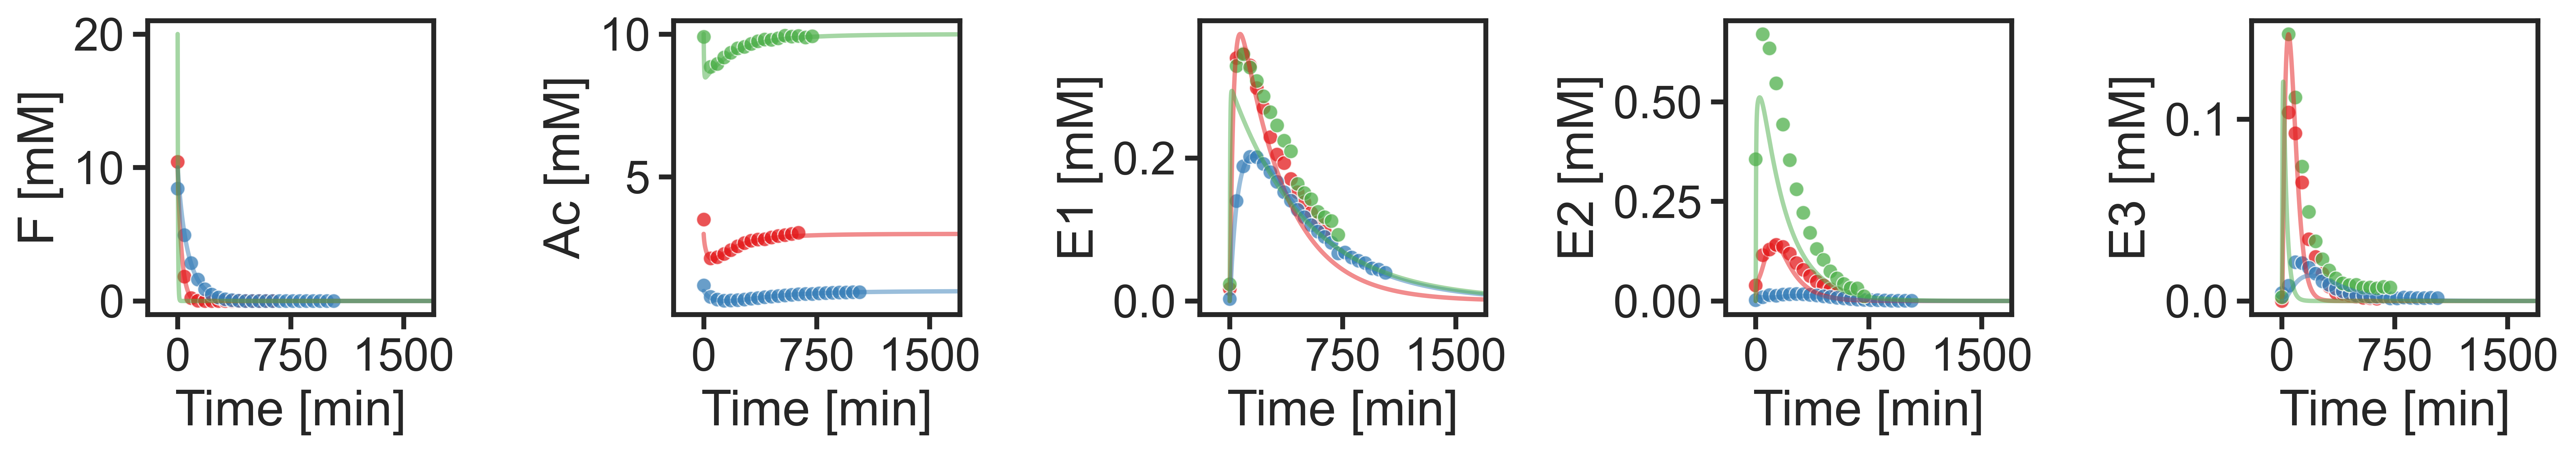

In [11]:
fig, ax = plot_reagent_data(exp_data, fit_data)
fig.dpi = 600

for i in ax:

    i.set(xlim = (-200, 1700), xticks = (0, 750, 1500))

In [14]:
k_values = pd.read_excel("k_values_Ac_AYRGD.xlsx")
k_values

,Unnamed: 0,Ac-AYRGD-OH_1,Ac-AYRGD-OH_2,Ac-AYRGD-OH_3
0,0,0.004500,0.004500,0.004500
1,1,0.011394,0.012247,0.042502
2,2,0.124292,0.029667,0.033754
3,3,0.314015,0.476764,0.466188
4,4,0.257612,0.000235,0.439634
5,5,0.094101,0.362770,0.381931
6,6,0.025408,0.167836,0.090061
7,7,0.114867,0.015754,0.057492
8,8,0.031524,0.096209,0.027431
9,9,0.096333,0.000102,0.076804


In [15]:
c = k_values["Ac-AYRGD-OH_1"]
cc = k_values["Ac-AYRGD-OH_2"]
ccc = k_values["Ac-AYRGD-OH_3"]

In [18]:
c.values

array([0.0045    , 0.01139428, 0.12429202, 0.31401541, 0.25761222,
       0.09410116, 0.02540806, 0.11486708, 0.03152369, 0.0963333 ,
       0.96612687, 0.0032589 , 0.00845009, 0.02979224])

# Calculate % of use

We use the set of k_values from the first condition, i.e. 10 mM EDC and 3 mM Precursor



In [20]:
# Initial conditions
ic_1 = [10,0,3., 0, 0,0,0,0]
ic_2 = [10,0,1., 0, 0,0,0,0]
ic_3 = [20,0,10., 0, 0,0,0,0]

sim1 = cy.get_fitted_curve(ic_1, tspan = np.linspace(0, 2000, 10000), params = c.values.flatten())
sim2 = cy.get_fitted_curve(ic_2, tspan = np.linspace(0, 2000, 10000), params = c.values.flatten())
sim3 = cy.get_fitted_curve(ic_3, tspan = np.linspace(0, 2000, 10000), params = c.values.flatten())

In [21]:
fit_data = [sim1, sim2, sim3]

## How much % of anhydride is form from EDC

In [31]:
# Define a list of conditions
conditions = [fit_data[0], fit_data[1], fit_data[2]]

# Define a list of kinetic constants
kinetic_constants = [c.iloc[0], c.iloc[1], c.iloc[7]]  # Assuming the relevant kinetic constants are at indices 0, 1, and 7 in the list

# Initialize an empty DataFrame to store the results
s = pd.DataFrame()

# Loop through each condition
for i, condition in enumerate(conditions):
    # Calculate the total amount of each species produced/consumed over time for the current condition
    p = [np.trapz(condition["F"], condition["min"]) * kinetic_constants[0],
         np.trapz(condition["Ac"] * condition["F"], condition["min"]) * kinetic_constants[1],
         np.trapz(condition["E2"] * condition["F"], condition["min"]) * kinetic_constants[2]]
    
    # Add the results for the current condition to the DataFrame
    s[f"Condition{i+1}"] = p

# Normalize the results to percentages
for column in s.columns:
    s[column + "_Percentage"] = 100 * s[column] / s[column].sum()

s["index"] = ["F➝W", "F➝An", "F➝An2"]
s

,Condition1,Condition2,Condition3,Condition1_Percentage,Condition2_Percentage,Condition3_Percentage,index
0,1.167942,3.215143,0.702120,11.679320,32.151361,3.510348,F➝W
1,7.165724,5.827591,14.270252,71.656619,58.275788,71.346176,F➝An
2,1.666421,0.957287,5.029053,16.664061,9.572851,25.143476,F➝An2


## How much An goes to E1 and E2



In [33]:
# Define the list of conditions
conditions = [fit_data[0], fit_data[1], fit_data[2]]

# Define the kinetic constants
kinetic_constants = [c[1], c[2], c[3], c[4], c[5], c[6]]  # Assuming the relevant kinetic constants are at indices 1 to 6

# Initialize an empty DataFrame to store the results
s2 = pd.DataFrame()

# Loop through each condition
for i, condition in enumerate(conditions):
    # Calculate the components of the list 'a', 'b', 'd' for the current condition
    a_component = np.trapz((condition["F"] * condition["Ac"]), condition["min"]) * (kinetic_constants[0] * kinetic_constants[1]) / (kinetic_constants[2] + kinetic_constants[1])
    b_component = np.trapz(condition["An"], condition["min"]) * kinetic_constants[3]
    c_component = np.trapz(condition["An"], condition["min"]) * kinetic_constants[4]
    d_component = np.trapz((condition["An"] * condition["Ac"]), condition["min"]) * kinetic_constants[5]

    # Add the components to the DataFrame for the current condition
    s2[f"Condition{i+1}"] = [a_component, b_component, c_component, d_component]

# Normalize the results to percentages
for column in s2.columns:
    s2[column + "_Percentage"] = 100 * s2[column] / s2[column].sum()

# Print or use the DataFrame 's2' as needed
s2["index"] = ["O➝An", "An➝Ac", "An➝E1","An➝E2"]
s2


,Condition1,Condition2,Condition3,Condition1_Percentage,Condition2_Percentage,Condition3_Percentage,index
0,2.032004,1.652546,4.046654,50.001984,50.000694,50.010498,O➝An
1,1.268444,1.150512,1.899943,31.212900,34.810772,23.480416,An➝Ac
2,0.463340,0.420262,0.694016,11.401518,12.715756,8.576979,An➝E1
3,0.300058,0.081726,1.450996,7.383598,2.472778,17.932107,An➝E2


## How much An goes to E1 and E2



In [34]:
# Define the list of conditions
conditions = [fit_data[0], fit_data[1], fit_data[2]]

# Define the kinetic constants
kinetic_constants = [c[10], c[13]]  # Assuming the relevant kinetic constants are at indices 10 to 3

# Initialize an empty DataFrame to store the results
s3 = pd.DataFrame()

# Loop through each condition
for i, condition in enumerate(conditions):
    # Calculate the components of the list 'a', 'b', 'd' for the current condition
    a_component = np.trapz(condition["An2"], condition["min"]) * kinetic_constants[0]

    b_component = np.trapz(condition["E3"], condition["min"]) * kinetic_constants[1]


    # Add the components to the DataFrame for the current condition
    s3[f"Condition{i+1}"] = [a_component, b_component]

# Normalize the results to percentages
for column in s3.columns:
    s3[column + "_Percentage"] = 100 * s3[column] / s3[column].sum()

# Print or use the DataFrame 's2' as needed
s3["index"] = ["An2➝E3", "E3➝E2"]
s3


,Condition1,Condition2,Condition3,Condition1_Percentage,Condition2_Percentage,Condition3_Percentage,index
0,0.410863,0.236024,1.239935,49.999988,50.000036,50.000003,An2➝E3
1,0.410863,0.236023,1.239935,50.000012,49.999964,49.999997,E3➝E2
